# Importing Libraries

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import re, os, sys, json, cv2, random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import torchvision
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Preprocessing

In [2]:
BASE_DIR = '/kaggle/input/selisedataset/dataset_256X256'
TRAIN_DIR = BASE_DIR + '/train'
TEST_DIR = BASE_DIR + '/test'
batch_size = 64

In [3]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=42)

In [4]:
def preprocess(root_dir):
    filepaths = []
    labels = []
    
    
    classes = [cla for cla in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, cla))]
    classes.sort()
    class_indices = {k: v for v, k in enumerate(classes)}
    
    every_class_num = []
    for klass in classes:
        classpath = os.path.join(root_dir, klass)
        images = [os.path.join(root_dir, klass, i) for i in os.listdir(classpath)]
        every_class_num.append(len(images))
        flist = sorted(os.listdir(classpath))
        for (index,f) in enumerate(flist):
            fpath = os.path.join(classpath, f)
            img = cv2.imread(fpath)
            filepaths.append(fpath)
            labels.append(klass)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    return df, class_indices
main_df, class_indices = preprocess(root_dir = TRAIN_DIR)
test_df, class_indices_test = preprocess(root_dir = TEST_DIR)

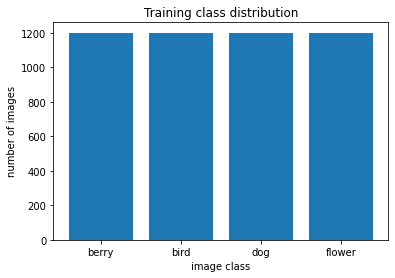

In [5]:
count_data = main_df.groupby(by='labels').count().reset_index()
plt.bar(count_data.labels, count_data.filepaths, align='center')
plt.xlabel('image class')
plt.ylabel('number of images')

plt.title('Training class distribution')
plt.show()

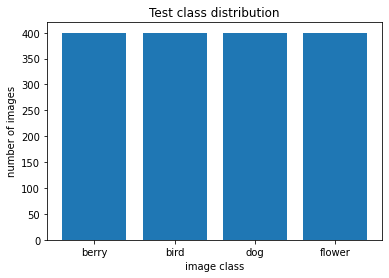

In [6]:
count_data = test_df.groupby(by='labels').count().reset_index()
plt.bar(count_data.labels, count_data.filepaths, align='center')
plt.xlabel('image class')
plt.ylabel('number of images')

plt.title('Test class distribution')
plt.show()

In [7]:
sample_df = main_df.sample(n=50, replace=False)
ht, wt, count = 0, 0, 0
for i in range(len(sample_df)):
    fpath = sample_df['filepaths'].iloc[i]
    try:
        img = cv2.imread(fpath)
        h = img.shape[0]
        w = img.shape[1]
        ht += h
        wt += w
        count += 1
    except:
        pass
have = int(ht / count)
wave = int(wt / count)
aspect_ratio = have / wave
print('average image height= ', have, '\n'
      'average image width= ', wave, '\n'
      'aspect ratio h/w= ', aspect_ratio)

average image height=  256 
average image width=  256 
aspect ratio h/w=  1.0


In [8]:
train_df, val_df = train_test_split(main_df, train_size=.8, shuffle=True,
                                     random_state=123, stratify=main_df['labels'])

train_image_path = train_df['filepaths'].tolist()
val_image_path = val_df['filepaths'].tolist()

train_image_label = [class_indices[i] for i in train_df['labels'].tolist()]
val_image_label = [class_indices[i] for i in val_df['labels'].tolist()]

test_image_path = test_df['filepaths'].tolist()
test_image_label = [class_indices[i] for i in test_df['labels'].tolist()]



print('{} Total Images\n{} for Training \n{} for validation \n{} for Inference'.format(
    len(train_image_path)+len(val_image_path)+len(test_image_path), 
    len(train_image_path), len(val_image_path), len(test_image_path)))

6400 Total Images
3840 for Training 
960 for validation 
1600 for Inference


# Dataset & Dataloader with Augmentation

In [9]:
class SeliseDataset(Dataset):
    def __init__(self, image_path, image_labels, transform=None) -> None:
        super().__init__()
        self.image_path = image_path
        self.image_class = image_labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, item):
        img = Image.open(self.image_path[item]).convert('RGB')
        label = self.image_class[item]
        
        if self.transform is not None:
            img = self.transform(img)
        return img, label
    
    @staticmethod
    def collate_fn(batch):
        images, labels = tuple(zip(*batch))
        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels   

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256), 
        transforms.ToTensor(), 
        transforms.RandomHorizontalFlip(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((256, 256)), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


train_dataset = SeliseDataset(train_image_path, train_image_label, 
                          transform=data_transform['train'])
trainloader = DataLoader(train_dataset, shuffle=True, 
                         batch_size=batch_size, num_workers=0, 
                         collate_fn=train_dataset.collate_fn)

valid_dataset = SeliseDataset(val_image_path, val_image_label, 
                          transform=data_transform['valid'])
validloader = DataLoader(valid_dataset, shuffle=False, 
                         batch_size=batch_size, num_workers=0, 
                         collate_fn=valid_dataset.collate_fn)

test_dataset = SeliseDataset(test_image_path, test_image_label, 
                          transform=data_transform['valid'])
testloader = DataLoader(test_dataset, shuffle=False, 
                         batch_size=batch_size, num_workers=0, 
                         collate_fn=test_dataset.collate_fn)

## Visualizing batch of augmented images

images.shape: torch.Size([64, 3, 256, 256])


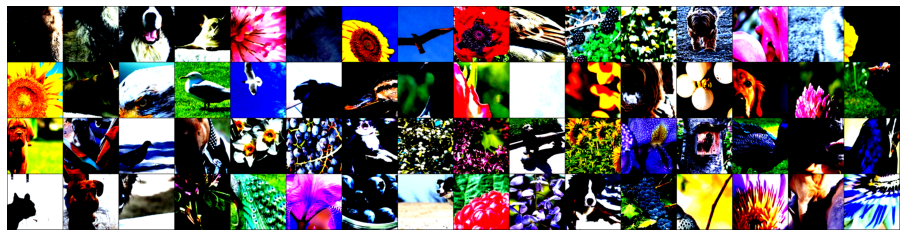

In [11]:
from torchvision.utils import make_grid

for images, _ in trainloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Model

In [12]:
def get_model(model):
    if model == 'resnext50_32x4d':
        model = torchvision.models.resnext50_32x4d(pretrained=True)
        #substitute the fc output layers
        model.fc = torch.nn.Linear(model.fc.in_features, 4)
        torch.nn.init.xavier_uniform_(model.fc.weight)
    elif model == 'efficientnetb0':
        model = torchvision.models.efficientnet_b0(pretrained=True)
        model.classifier = torch.nn.Linear(1280, 4)
        torch.nn.init.xavier_uniform_(model.classifier.weight)
    else:
        print("Accurate/No model was stated")
    return model

# Training

## Resnet Training

In [13]:
import time

def train(net, train_dataloader, valid_dataloader, criterion, optimizer,
          scheduler=None, epochs=10, device='cpu', checkpoint_epochs=5):
    
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')
    
    save_path = '/kaggle/working/ResNext50.pth'
    best_val_acc = 0.0
    training_metrics = []
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}")
        
        net.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_accuracy = torch.tensor(0., device=device)
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
            preds = net(X)
            loss = criterion(preds, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == y).sum()
        
        if valid_dataloader is not None:
            net.eval()  # put network in train mode for Dropout and Batch Normalization
            valid_loss = torch.tensor(0., device=device)
            valid_accuracy = torch.tensor(0., device=device)
            with torch.no_grad():
                for X, y in valid_dataloader:
                    X = X.to(device)
                    y = y.to(device)
                    preds = net(X)
                    loss = criterion(preds, y)

                    valid_loss += loss * valid_dataloader.batch_size
                    valid_accuracy += (torch.argmax(preds, dim=1) == y).sum()
        
        if scheduler is not None: 
            scheduler.step()
        
        train_loss = train_loss/len(train_dataloader.dataset)
        train_accuracy = 100*train_accuracy/len(train_dataloader.dataset)
        print(f'Training loss: {train_loss:.3f}')
        print(f'Training accuracy: {train_accuracy:.3f}')
        
        if valid_dataloader is not None:
            valid_loss = valid_loss/len(valid_dataloader.dataset)
            valid_accuracy = 100*valid_accuracy/len(valid_dataloader.dataset)
            print(f'Valid loss: {valid_loss:.3f}')
            print(f'Valid accuracy: {valid_accuracy:.3f}')
        

        metric_dict = {
            'epoch' : epoch,
            'train_loss' : train_loss.cpu().numpy(),
            'train_accuracy' : train_accuracy.cpu().numpy(),
            'valid_loss' : valid_loss.cpu().numpy(),
            'valid_accuracy' : valid_accuracy.cpu().numpy()
        }
        training_metrics.append(metric_dict)
        print()
        
        if valid_accuracy > best_val_acc:
            best_val_acc = valid_accuracy
            torch.save(net.state_dict(), save_path)
    
    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net, training_metrics

In [14]:
lr, weight_decay, epochs = 1e-5, 5e-4, 20


model = get_model(model = 'resnext50_32x4d').to(device)

# Standard CrossEntropy Loss for multi-class classification problems
criterion = torch.nn.CrossEntropyLoss()

# params_1x are the parameters of the network body, i.e., of all layers except the FC layers
params_1x = [param for name, param in model.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.Adam([{'params': params_1x}, 
                              {'params': model.fc.parameters(), 'lr': lr*10}], 
                             lr=lr, weight_decay=weight_decay)

net, training_metrics = train(model, trainloader, validloader,
                              criterion, optimizer, None, epochs,device)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

Training for 20 epochs on cuda
Epoch 1/20
Training loss: 0.484
Training accuracy: 86.328
Valid loss: 0.088
Valid accuracy: 98.854

Epoch 2/20
Training loss: 0.109
Training accuracy: 97.188
Valid loss: 0.036
Valid accuracy: 99.792

Epoch 3/20
Training loss: 0.075
Training accuracy: 97.813
Valid loss: 0.023
Valid accuracy: 99.792

Epoch 4/20
Training loss: 0.064
Training accuracy: 98.047
Valid loss: 0.018
Valid accuracy: 99.896

Epoch 5/20
Training loss: 0.055
Training accuracy: 98.359
Valid loss: 0.016
Valid accuracy: 99.896

Epoch 6/20
Training loss: 0.052
Training accuracy: 98.307
Valid loss: 0.013
Valid accuracy: 99.896

Epoch 7/20
Training loss: 0.043
Training accuracy: 98.646
Valid loss: 0.012
Valid accuracy: 99.896

Epoch 8/20
Training loss: 0.041
Training accuracy: 98.542
Valid loss: 0.014
Valid accuracy: 99.688

Epoch 9/20
Training loss: 0.039
Training accuracy: 98.594
Valid loss: 0.011
Valid accuracy: 99.896

Epoch 10/20
Training loss: 0.029
Training accuracy: 98.984
Valid loss

## ResNet Training & Validation Loss/Accuracy

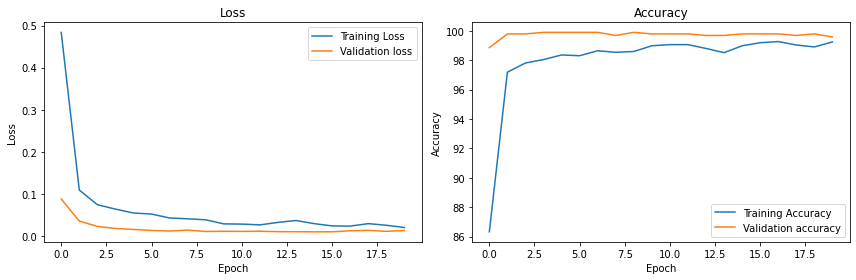

In [15]:
metrics = pd.DataFrame(training_metrics)

f, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(metrics.train_loss, label="Training Loss")
ax[0].plot(metrics.valid_loss, label="Validation loss")
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Accuracy
ax[1].plot(metrics.train_accuracy, label="Training Accuracy")
ax[1].plot(metrics.valid_accuracy, label="Validation accuracy")
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()

In [16]:
metrics.to_csv('resnet_training_metrics.csv', index=False)

## ResNet Test

In [17]:
def test_predictor(testloader, model):
    errors = 0
    y_pred, y_true = [], []
    checkpoint = torch.load('ResNext50.pth')
    model.load_state_dict(checkpoint)

    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(len(preds)):
                y_pred.append(preds[i].cpu())
                y_true.append(labels[i].cpu())
    
    tests = len(y_pred)
    for i in range(tests):
        pred_index = y_pred[i]
        true_index = y_true[i]
        if pred_index != true_index:
            errors += 1
    acc = (1 - errors / tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%')
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    return ytrue, ypred

In [18]:
ytrue_1, ypred_1 = test_predictor(testloader, net)

there were 11 errors in 1600 tests for an accuracy of  99.31%


## Resnet Classification Test Report

Test accuracy is 99.3125%
F1 score is 99.3127 %


<AxesSubplot:>

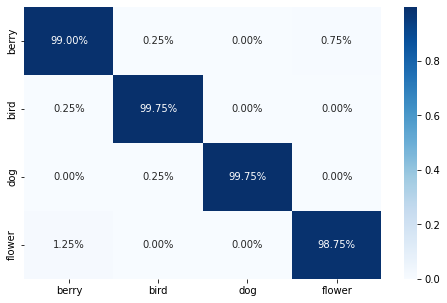

In [19]:
print(f"Test accuracy is {round(np.mean(ytrue_1 == ypred_1)*100,4)}%")
print('F1 score is',round(f1_score(ytrue_1,ypred_1, average = 'weighted') *100,4), "%")
cf_matrix = confusion_matrix(ytrue_1,ypred_1 )
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix,axis=1),
                     index = [i for i in class_indices],
                     columns = [i for i in class_indices])
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, fmt='.2%',annot=True, cmap='Blues')

## EfficientNet Training

In [20]:
import time

def train(net, train_dataloader, valid_dataloader, criterion, optimizer,
          scheduler=None, epochs=10, device='cpu', checkpoint_epochs=5):
    
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')
    
    save_path = '/kaggle/working/EfficientNetB0.pth'
    best_val_acc = 0.0
    training_metrics = []
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}")
        
        net.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_accuracy = torch.tensor(0., device=device)
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
            preds = net(X)
            loss = criterion(preds, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == y).sum()
        
        if valid_dataloader is not None:
            net.eval()  # put network in train mode for Dropout and Batch Normalization
            valid_loss = torch.tensor(0., device=device)
            valid_accuracy = torch.tensor(0., device=device)
            with torch.no_grad():
                for X, y in valid_dataloader:
                    X = X.to(device)
                    y = y.to(device)
                    preds = net(X)
                    loss = criterion(preds, y)

                    valid_loss += loss * valid_dataloader.batch_size
                    valid_accuracy += (torch.argmax(preds, dim=1) == y).sum()
        
        if scheduler is not None: 
            scheduler.step()
        
        train_loss = train_loss/len(train_dataloader.dataset)
        train_accuracy = 100*train_accuracy/len(train_dataloader.dataset)
        print(f'Training loss: {train_loss:.3f}')
        print(f'Training accuracy: {train_accuracy:.3f}')
        
        if valid_dataloader is not None:
            valid_loss = valid_loss/len(valid_dataloader.dataset)
            valid_accuracy = 100*valid_accuracy/len(valid_dataloader.dataset)
            print(f'Valid loss: {valid_loss:.3f}')
            print(f'Valid accuracy: {valid_accuracy:.3f}')
        

        metric_dict = {
            'epoch' : epoch,
            'train_loss' : train_loss.cpu().numpy(),
            'train_accuracy' : train_accuracy.cpu().numpy(),
            'valid_loss' : valid_loss.cpu().numpy(),
            'valid_accuracy' : valid_accuracy.cpu().numpy()
        }
        training_metrics.append(metric_dict)
        print()
        
        if valid_accuracy > best_val_acc:
            best_val_acc = valid_accuracy
            torch.save(net.state_dict(), save_path)
    
    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net, training_metrics

In [21]:
lr, weight_decay, epochs = 1e-5, 5e-4, 20


model = get_model(model = 'efficientnetb0').to(device)

# Standard CrossEntropy Loss for multi-class classification problems
criterion = torch.nn.CrossEntropyLoss()

# params_1x are the parameters of the network body, i.e., of all layers except the FC layers
params_1x = [param for name, param in model.named_parameters() if 'classifier' not in str(name)]
optimizer = torch.optim.Adam([{'params': params_1x}, 
                              {'params': model.classifier.parameters(), 'lr': lr*10}], 
                             lr=lr, weight_decay=weight_decay)

effnet, eff_training_metrics = train(model, trainloader, validloader,
                              criterion, optimizer, None, epochs,device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

Training for 20 epochs on cuda
Epoch 1/20
Training loss: 1.171
Training accuracy: 51.432
Valid loss: 0.876
Valid accuracy: 76.563

Epoch 2/20
Training loss: 0.682
Training accuracy: 85.417
Valid loss: 0.495
Valid accuracy: 92.188

Epoch 3/20
Training loss: 0.442
Training accuracy: 91.198
Valid loss: 0.301
Valid accuracy: 95.625

Epoch 4/20
Training loss: 0.302
Training accuracy: 93.802
Valid loss: 0.211
Valid accuracy: 96.875

Epoch 5/20
Training loss: 0.231
Training accuracy: 94.375
Valid loss: 0.160
Valid accuracy: 97.292

Epoch 6/20
Training loss: 0.213
Training accuracy: 94.297
Valid loss: 0.132
Valid accuracy: 97.292

Epoch 7/20
Training loss: 0.166
Training accuracy: 95.651
Valid loss: 0.109
Valid accuracy: 97.708

Epoch 8/20
Training loss: 0.151
Training accuracy: 95.573
Valid loss: 0.097
Valid accuracy: 97.917

Epoch 9/20
Training loss: 0.136
Training accuracy: 96.042
Valid loss: 0.085
Valid accuracy: 97.813

Epoch 10/20
Training loss: 0.128
Training accuracy: 96.146
Valid loss

## EfficientNet Training & Validation Loss/Accuracy

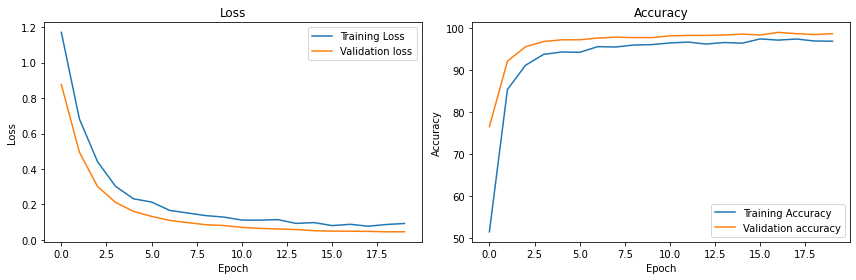

In [22]:
metrics = pd.DataFrame(eff_training_metrics)

f, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(metrics.train_loss, label="Training Loss")
ax[0].plot(metrics.valid_loss, label="Validation loss")
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Accuracy
ax[1].plot(metrics.train_accuracy, label="Training Accuracy")
ax[1].plot(metrics.valid_accuracy, label="Validation accuracy")
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()

In [23]:
metrics.to_csv("effnet_training_metrics.csv",index=False)

## EfficientNet Test

In [24]:
def test_predictor(testloader, model):
    errors = 0
    y_pred, y_true = [], []
    checkpoint = torch.load('EfficientNetB0.pth')
    model.load_state_dict(checkpoint)

    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(len(preds)):
                y_pred.append(preds[i].cpu())
                y_true.append(labels[i].cpu())
    
    tests = len(y_pred)
    for i in range(tests):
        pred_index = y_pred[i]
        true_index = y_true[i]
        if pred_index != true_index:
            errors += 1
    acc = (1 - errors / tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%')
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    return ytrue, ypred

In [25]:
model = get_model(model = 'efficientnetb0').to(device)
ytrue_2, ypred_2 = test_predictor(testloader, model)

there were 25 errors in 1600 tests for an accuracy of  98.44%


## EfficientNet Classification Test Report

Test accuracy is 98.4375%
F1 score is 98.4382 %


<AxesSubplot:>

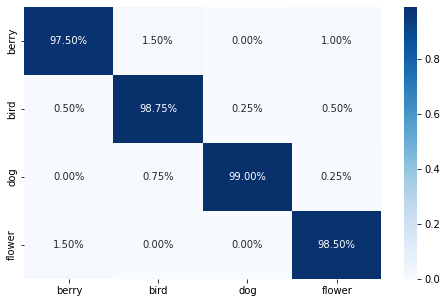

In [26]:
print(f"Test accuracy is {round(np.mean(ytrue_2 == ypred_2)*100,4)}%")
print('F1 score is',round(f1_score(ytrue_2,ypred_2, average = 'weighted') *100,4), "%")
cf_matrix_2 = confusion_matrix(ytrue_2,ypred_2 )
df_cm_2 = pd.DataFrame(cf_matrix_2/np.sum(cf_matrix_2,axis=1),
                     index = [i for i in class_indices],
                     columns = [i for i in class_indices])
plt.figure(figsize = (8,5))
sns.heatmap(df_cm_2, fmt='.2%',annot=True, cmap='Blues')

# Weighted Ensemble

In [27]:
pred = 0.5*ypred_1 + 0.5*ypred_2
print(f"Ensemble accuracy is {round(np.mean(ytrue_1 == pred)*100,4)}%")

Ensemble accuracy is 98.125%


# Inference

In [28]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img_path = TEST_DIR + '/bird/100_256.jpg'

def pre_image(image_path,model, class_indices):
    img = Image.open(image_path)
    mean = [0.485, 0.456, 0.406] 
    std = [0.229, 0.224, 0.225]
    transform_norm = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Resize((256,256)),
        transforms.Normalize(mean, std)])
    # get normalized image
    img_normalized = transform_norm(img).float()
    img_normalized = img_normalized.unsqueeze_(0)
    # input = Variable(image_tensor)
    img_normalized = img_normalized.to(device)
    print(img_normalized.shape)
    with torch.no_grad():
        model.eval()  
        output =model(img_normalized)
        index = output.data.cpu().numpy().argmax()
        classs = {i for i in class_indices if class_indices[i]==index}
        return classs

In [29]:
predict_class = pre_image(image_path = img_path,model=model, class_indices=class_indices)
print(predict_class)

torch.Size([1, 3, 256, 256])
{'bird'}
